# Water Potability EDA & Prediction
------

## Importing Libraries and our dataset and intializing some variables and some Functions that we will need in the future
------------------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score 
import mplcyberpunk
from matplotlib import cm
from matplotlib.patches import Circle
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import  QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score,mean_squared_error
import matplotlib.patheffects as pe
from sklearn.impute import KNNImputer
plt.style.use("cyberpunk")
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings("ignore")
accuracies=[[] for i in range(8)]
counts=0

df=pd.read_csv("water_potability.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [3]:
def Graph(accuracies):
    colors = ['#29B2A0','#DD4F00','#983F4A','#F5F5F4','#B0744A','#FFB301','#1135A5','r']
    titles=['Dropping NAN','Filling Mean/Median','Interpolate(PAD)','Interpolate(INDEX)',
    'Interpolate(Polynomial)','Interpolate(Linear)','Capping MAX/MIN(Median)','Categories']
    methods=["KNN",'Logistic','SVC',"LDA","QDA"]
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    x_axis=np.arange(len(methods))
    n=-0.3
    for accuracy,title,color in zip(accuracies,titles,colors):
        ax.bar(x_axis+n,height=accuracy,width=0.1,color=color,align='center',label=title)
        ax.set_xticks(x_axis,methods,fontsize=14)
        ax.legend(loc='best',fontsize=15)
        ax.set_ylim(bottom=50, top=75)
        n+=0.1
        ax.set_yticks(range(50,76,5))
        ax.tick_params(axis='y',labelsize=13)

          
def Graphs(accuracies):
    colormap_sect = np.linspace(0.3, 0.8, 5)
    colors = [cm.coolwarm(x) for x in colormap_sect]
    titles=['Dropping NAN','Filling Mean/Median','Interpolate(Pad)','Interpolate(Index)',
    'Interpolate(Polynomial)','Interpolate(Linear)','Capping MAX/MIN(Median)','Categories']
    methods=["KNN",'Logistic','SVC',"LDA","QDA"]
    figure, (axis) = plt.subplots(4, 2,figsize=(20,20),constrained_layout = True)
    for title,accuracy,ax in zip(titles,accuracies,axis.ravel()):
        ax.bar(x=methods,height=accuracy,color=colors,edgecolor=colors,linewidth=4)
        ax.set_title(title,fontsize=18)
        ax.grid(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x',labelsize=13)
        for i,z in enumerate(accuracy):
            ax.text(i,z/2, z.round(3), ha = 'center',fontdict={'color':'#212946','fontsize':15}) 
    line = plt.Line2D((.5,.5),(.01,1), color="w", linewidth=3)
    figure.add_artist(line)
  
        

### We Will use some ML Models to choose the accuracy with the best method of filling

In [4]:
def models_func(Df):
    Y=Df.Potability.values
    X=Df[Df.columns.difference(['Potability'])].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25,random_state=42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    models = [
        ("KNN",KNeighborsClassifier()),
        ('Logistic', LogisticRegression(max_iter=1000,random_state=42)),
        ('SVC', SVC(kernel='rbf')),
        ("LDA",LDA()),
        ("QDA",QDA())
    ]

    results = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        score = accuracy_score(y_test, pred)    
        mse = mean_squared_error(y_test, pred) 
        cvs=np.array(cross_val_score(model,X,Y,cv=4))
        results[name] = [(score*100).round(3),(mse*100).round(3),(cvs.mean()*100).round(3)]
        accuracies[counts].append(score*100)
    return results


------------------------------------------
## First, we need to check our data if 
----------------------------
1. There are any missing values
2. Units that need to match the dataset
3. There is any outliers
4. It is skewed or normally distributed 
5. There is any correlation between the variables

### 1) Missing Values

ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64

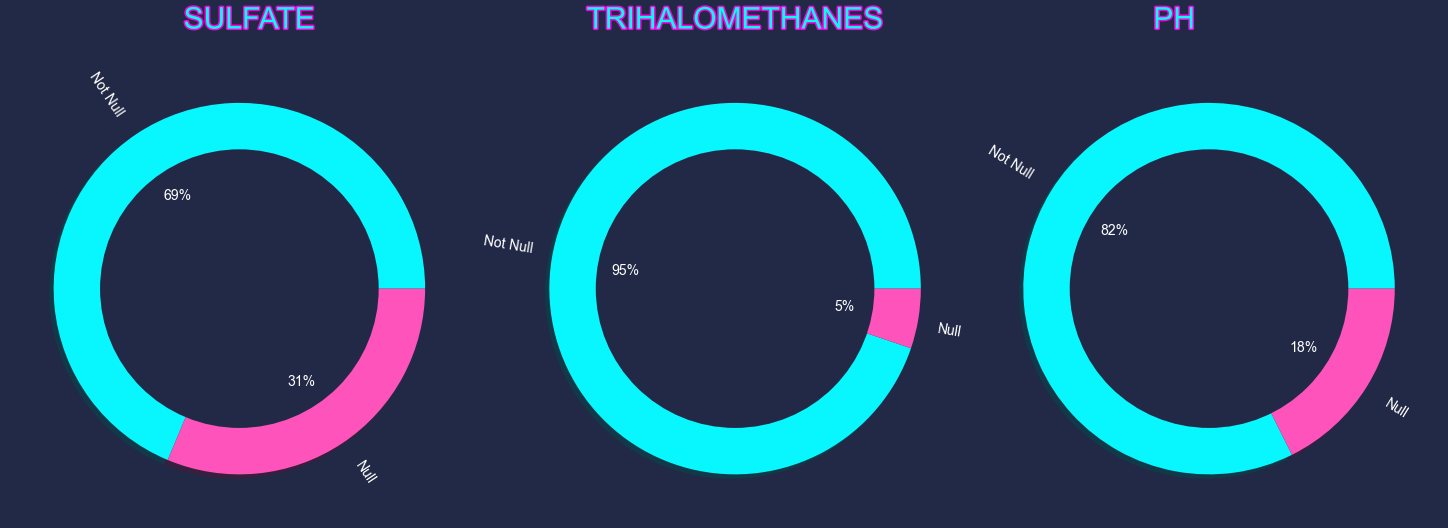

In [5]:
display(df.isnull().sum()[df.isnull().sum()>0])
figure, (axis) = plt.subplots(1, 3,figsize=(20,40),constrained_layout = True)
for column,ax in zip(['Sulfate',"Trihalomethanes",'ph'],axis.ravel()):
    n=-.8 if column=="Trihalomethanes" else -.3
    ax.pie([(df[column].count()-(df[column].isnull()==True).sum()),(df[column].isnull()==True).sum()], labels = ['Not Null','Null'], autopct='%.0f%%',rotatelabels='true',shadow=True,textprops={'fontsize': 14,'color':'w'})
    txt = ax.text(n, 1.4, column.upper(),
              size=30,
              color='#00FFEF',
              path_effects=[pe.withStroke(linewidth=3, foreground="#FF00DE")])
    circle=Circle(xy=(0,0),radius=0.75,facecolor='#212946')
    ax.add_patch(circle)

### 2) Units that need to match the dataset


According to the data set info on kaggle 


we need to change the value of trihalomethanes (microliter->milliliter)

In [6]:
print(df.Trihalomethanes.head())
df.Trihalomethanes=df.Trihalomethanes*0.001
df.Trihalomethanes.head()


0     86.990970
1     56.329076
2     66.420093
3    100.341674
4     31.997993
Name: Trihalomethanes, dtype: float64


0    0.086991
1    0.056329
2    0.066420
3    0.100342
4    0.031998
Name: Trihalomethanes, dtype: float64

### 3) There is any outliers

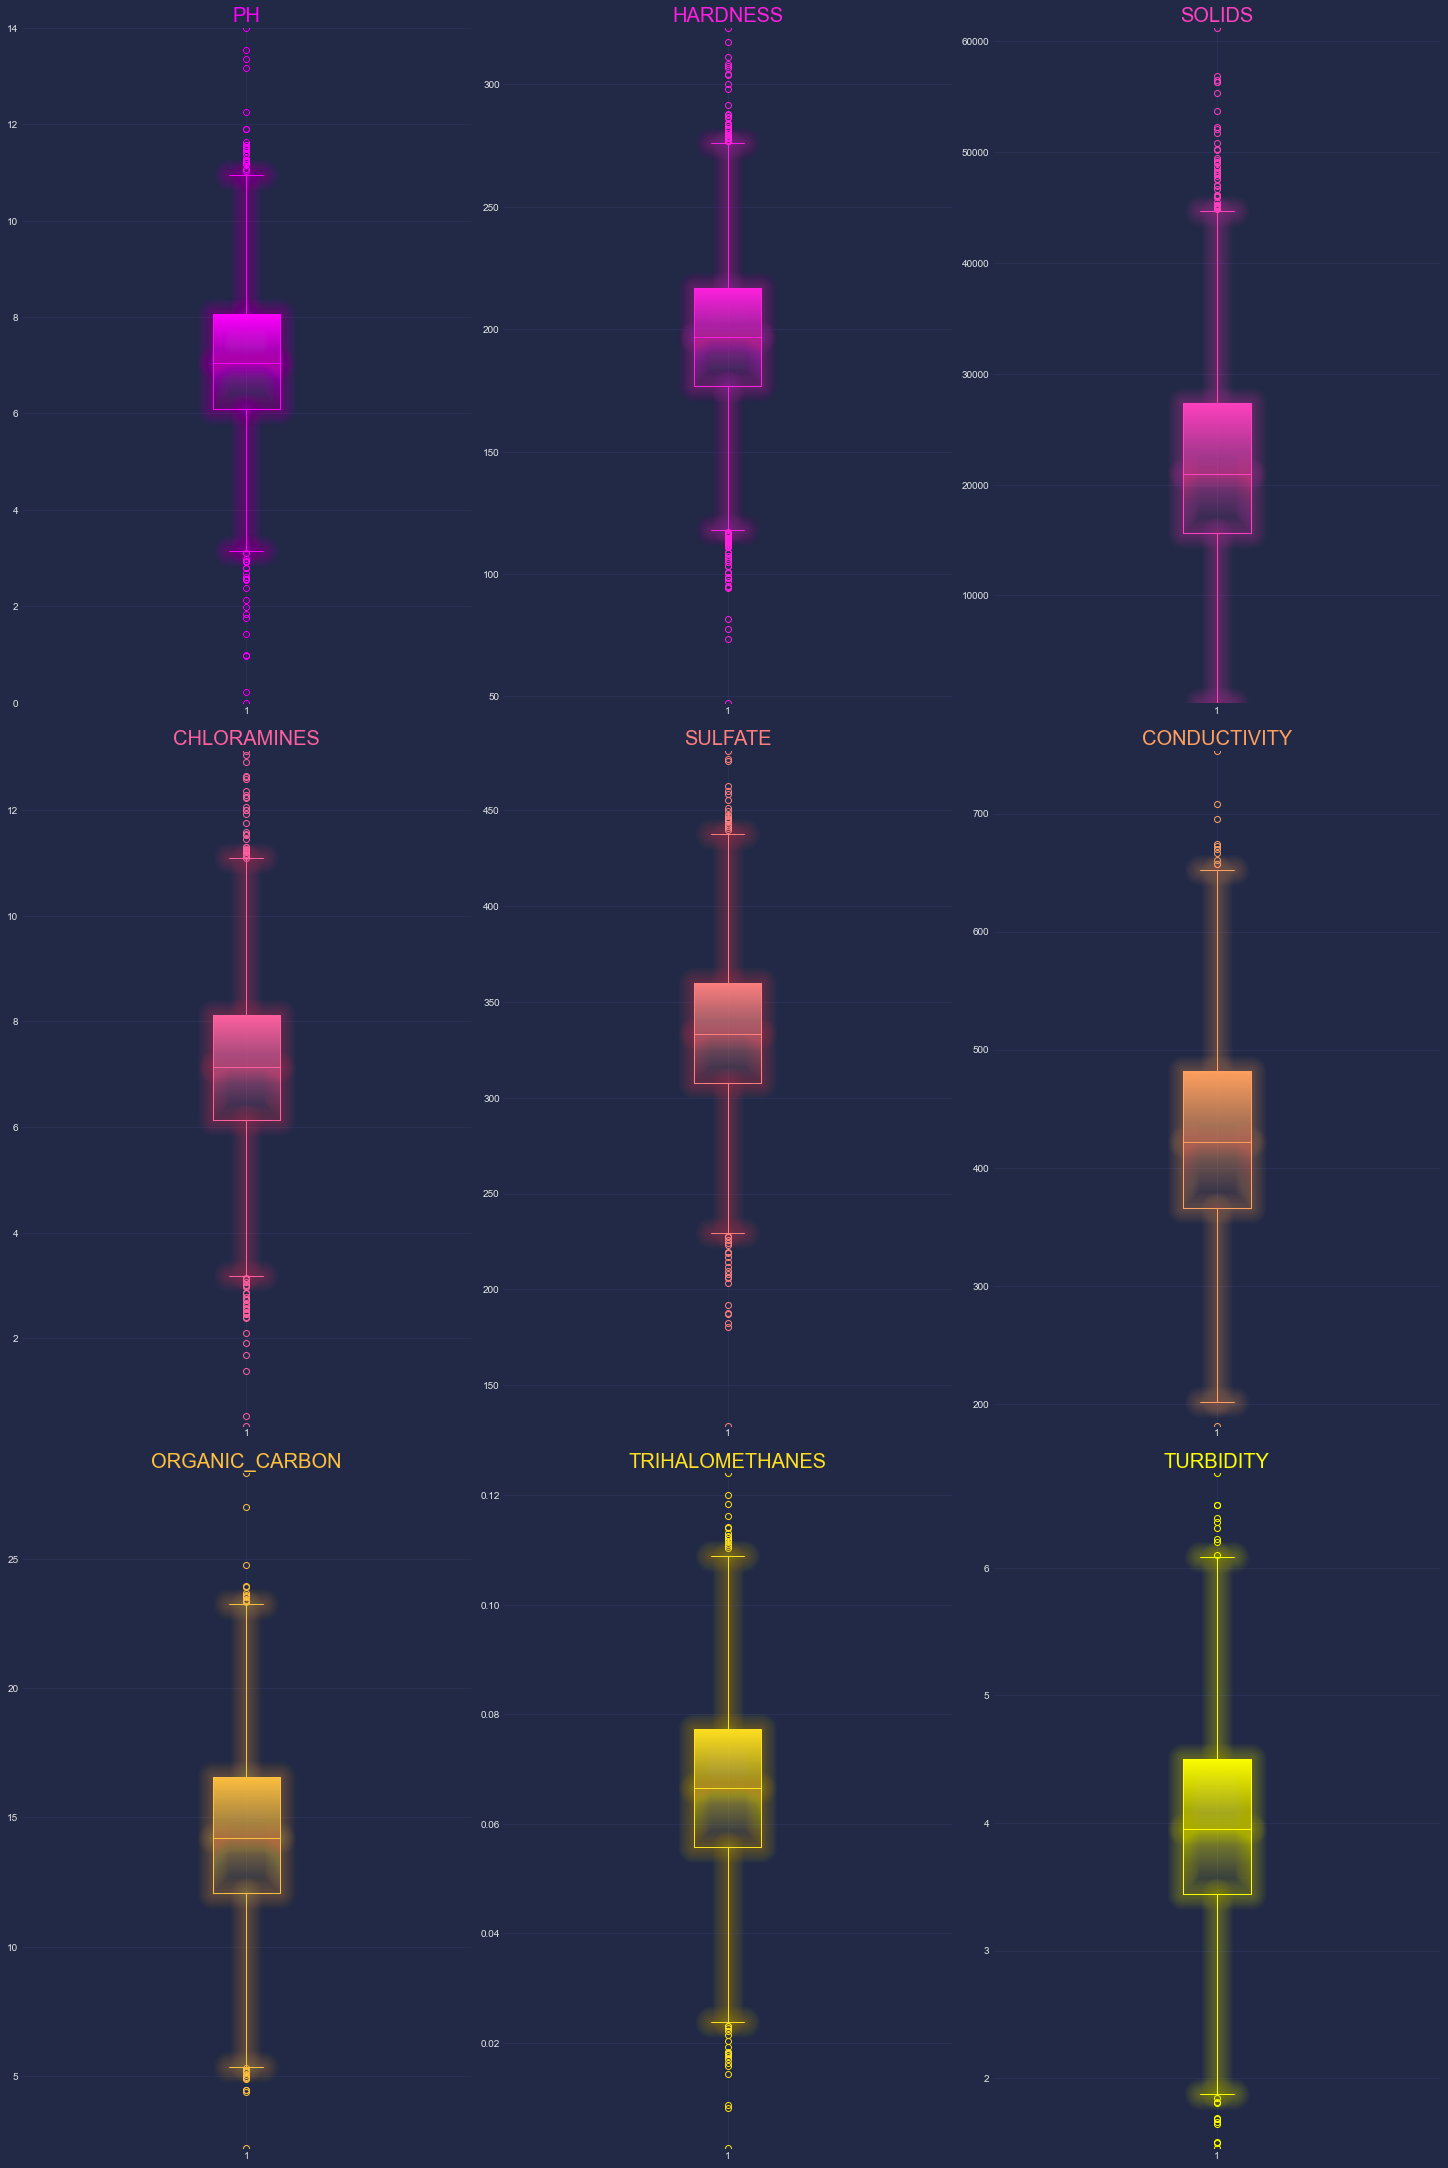

In [7]:
plt.style.use("cyberpunk")
colormap_sect = np.linspace(0, 1, 9)
colors = [cm.spring(x) for x in colormap_sect]
figure, (axis) = plt.subplots(3, 3,figsize=(20,30),constrained_layout = True)
for column,ax,color in zip(df.keys(),axis.ravel(),colors):
    ax.boxplot(df[column].dropna(), boxprops=dict( color=color),
            capprops=dict(color=color),
            whiskerprops=dict(color=color),
            flierprops=dict(color=color, markeredgecolor=color),
            medianprops=dict(color=color))
    ax.set_title(f"{column.upper()}",size=20,color=color)
    mplcyberpunk.add_gradient_fill(ax,alpha_gradientglow=1)
    mplcyberpunk.make_lines_glow(ax,n_glow_lines=30)

#### The data has some outliers in all columns except Potability

### 4) Skewed or normally distributed data

In [8]:
df.skew(axis="index")

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
Potability         0.450784
dtype: float64

#### Our data has a small skewness but it's acceptable 

### 5) variables correlation

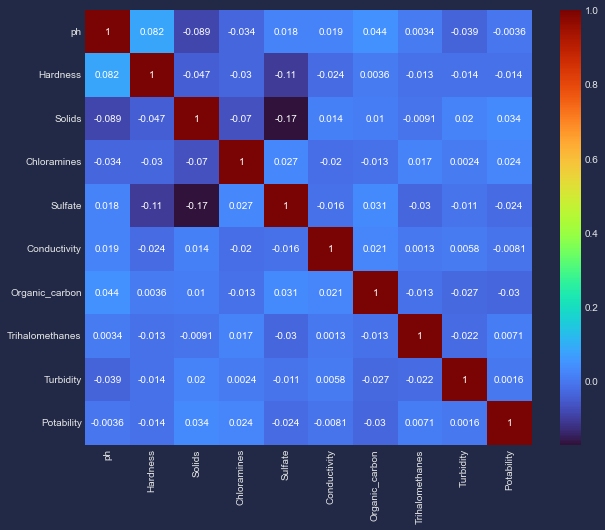

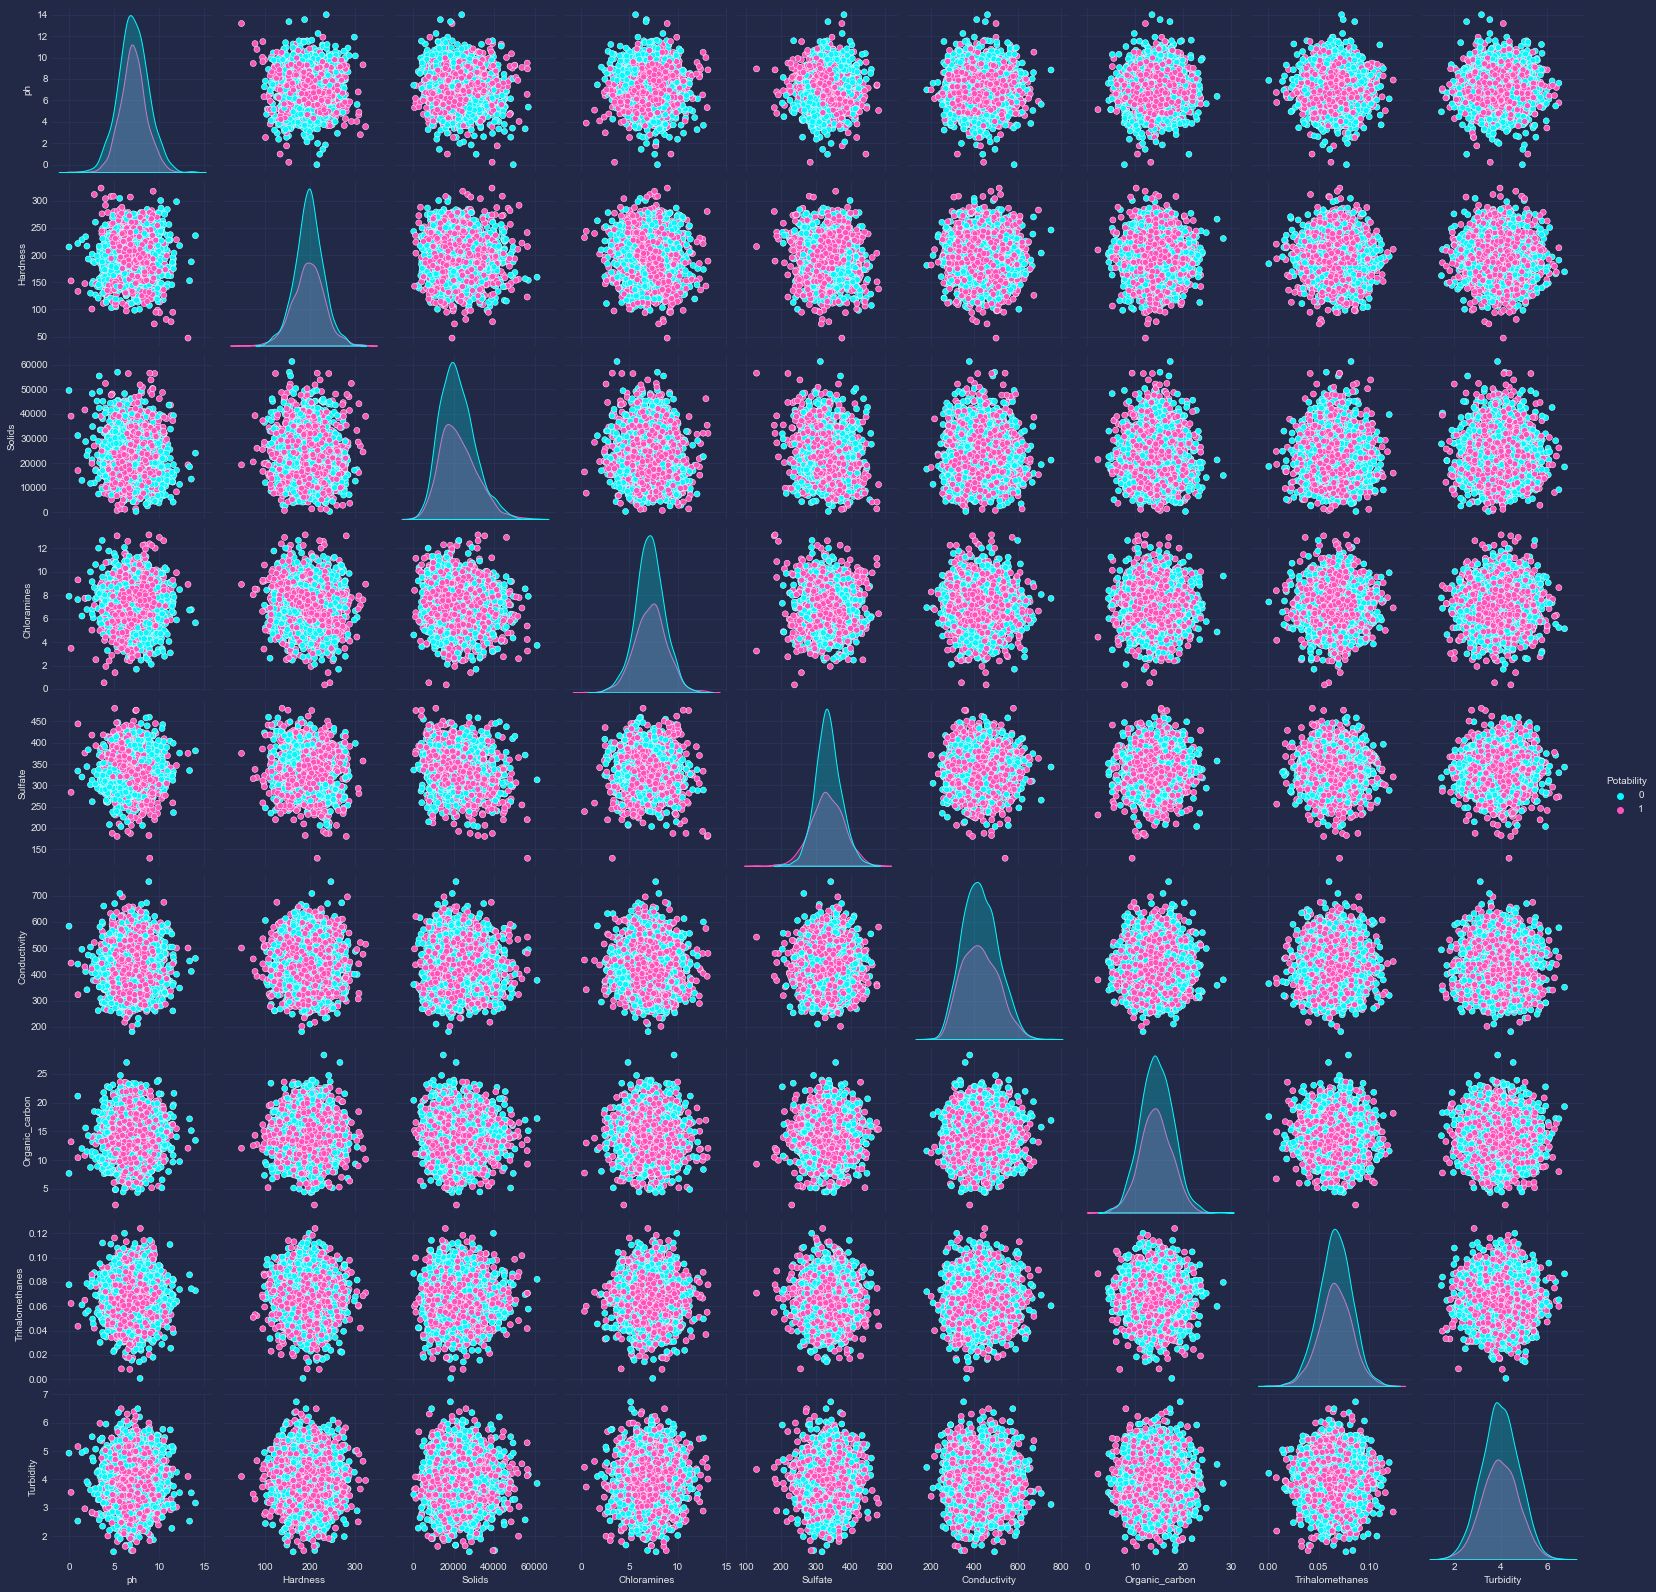

In [9]:
plt.figure(figsize=(10, 8))
al=sns.heatmap(df.corr(),annot=True,cmap='turbo')
sns.pairplot(df,hue='Potability')

#### There isn't  any correlations between our variables


---------
## Second, we need to find out a way to deal with these missing values

### So we will use diffrent ways to deal with the missing data
----------------------------------
1. dropping the missing will cause a great lose in data
2. Median/Mean
3. interpolate function from panads(3 methods)
4. Capping the outlier and filling with the mean/median
5. KNN ML model

#### 1) Dropping the missing data
------

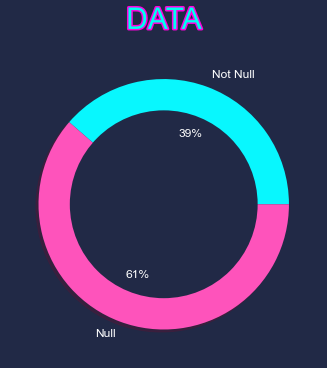

In [10]:
figure, (axis) = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True)
axis.pie([df.shape[0]-df.dropna().shape[0],df.dropna().shape[0]], labels = ['Not Null','Null'], autopct='%.0f%%',shadow=True,textprops={'fontsize': 12,'color':'w'})
circle=Circle(xy=(0,0),radius=0.75,facecolor='#212946')
axis.add_patch(circle)
txt = axis.text(-0.3, 1.4, "DATA",
              size=30,
              color='#00FFEF',
              path_effects=[pe.withStroke(linewidth=3, foreground='#FF00DE')])

So Now we will lose 39% of our data if we dropped the missing value
But let's see how the models will perform

In [11]:
dropped_df=df.dropna().reset_index(drop=True).copy()
drop_results=models_func(dropped_df)
counts+=1
drop_results


{'KNN': [62.227, 37.773, 55.097],
 'Logistic': [58.648, 41.352, 59.672],
 'SVC': [68.986, 31.014, 59.672],
 'LDA': [58.648, 41.352, 59.97],
 'QDA': [67.992, 32.008, 60.918]}

#### 2) Imputation With Mean/Median
------
As we viewed in the previous section that we have nulls in the Ph ,Sulfate & Trihalomethanes,
So we will fill them with their means/medians

As our data is normally distributed then the mean and the median are very close

In [12]:
f_df=df.copy()
print('Difference Between Mean and Median')
print('PH:',f_df.ph.mean()-f_df.ph.median())
print('Sulfate:',f_df.Sulfate.mean()-f_df.Sulfate.median())
print('Trihalomethanes:',f_df.Trihalomethanes.mean()-f_df.Trihalomethanes.median())

Difference Between Mean and Median
PH: 0.044042400443287555
Sulfate: 0.7022308649255251
Trihalomethanes: -0.00022619215131680637


In [13]:
f_df.fillna(f_df.median(),inplace=True)
med_results=models_func(f_df)
counts+=1
med_results

{'KNN': [62.515, 37.485, 55.586],
 'Logistic': [62.271, 37.729, 60.989],
 'SVC': [69.719, 30.281, 60.989],
 'LDA': [62.271, 37.729, 61.081],
 'QDA': [68.132, 31.868, 59.86]}

#### 3)using intrpolate function
---------

##### A) Using Pad
---------------------------
Uses either the previous or next non-NaN value to fill

In [14]:
pad_result=models_func(df.sort_values(by=['Turbidity','Organic_carbon','Conductivity','Chloramines','Solids','Hardness'],ascending=True).interpolate(method='pad'))
counts+=1
pad_result

{'KNN': [62.759, 37.241, 55.586],
 'Logistic': [62.515, 37.485, 60.989],
 'SVC': [66.545, 33.455, 60.958],
 'LDA': [62.515, 37.485, 60.958],
 'QDA': [66.545, 33.455, 66.087]}

##### B) Using Index
-------------
Uses the actual index to fill the NAN values


In [15]:
index_result=models_func(df.sort_values(by=['Turbidity','Organic_carbon','Conductivity','Chloramines','Solids','Hardness'],ascending=True).interpolate(method='index'))
counts+=1
index_result

{'KNN': [60.928, 39.072, 55.708],
 'Logistic': [62.637, 37.363, 60.989],
 'SVC': [66.789, 33.211, 60.958],
 'LDA': [62.637, 37.363, 61.05],
 'QDA': [66.911, 33.089, 66.972]}

##### C) Using Polynomial
-------------------------------
Uses a Polynomial function to predict the NAN values

In [16]:
poly_result=models_func(df.sort_values(by=['Turbidity','Organic_carbon','Conductivity','Chloramines','Solids','Hardness'],ascending=True).interpolate(method='polynomial',order=5).bfill().ffill())
counts+=1
poly_result


{'KNN': [61.294, 38.706, 55.433],
 'Logistic': [62.759, 37.241, 61.142],
 'SVC': [65.934, 34.066, 60.958],
 'LDA': [62.759, 37.241, 61.142],
 'QDA': [65.568, 34.432, 65.171]}

##### D) Using Linear
--------------------------
Uses a Linear function to predict the NAN values

In [17]:
lin_result=models_func(df.sort_values(by=['Turbidity','Organic_carbon','Conductivity','Chloramines','Solids','Hardness'],ascending=True).interpolate(method='linear'))
counts+=1
lin_result

{'KNN': [63.004, 36.996, 55.495],
 'Logistic': [62.515, 37.485, 60.989],
 'SVC': [67.399, 32.601, 60.958],
 'LDA': [62.515, 37.485, 60.958],
 'QDA': [66.422, 33.578, 65.72]}

#### 4) Capping At MAX/MIN Limit
--------------

In [18]:
df_cap=df.copy()
for col in df_cap.keys():
    q1 = df_cap[col].quantile(0.25)
    q2 = df_cap[col].quantile(0.75)
    max_limit = q2 + (1.5 * (q2-q1))
    min_limit = q1 - (1.5 * (q2-q1))
    df_cap[col]=pd.DataFrame(np.where(df_cap[col] >  max_limit, max_limit, 
         (np.where(df_cap[col]< min_limit, min_limit, df_cap[col]))))


In [19]:
df_cap.fillna(df_cap.median(),inplace=True)
n=models_func(df_cap)
counts+=1
n

{'KNN': [62.637, 37.363, 55.311],
 'Logistic': [62.271, 37.729, 60.989],
 'SVC': [69.353, 30.647, 60.989],
 'LDA': [62.271, 37.729, 61.02],
 'QDA': [68.01, 31.99, 59.737]}

#### 5)Filling NAN values using KNN

In [20]:
df_cat=df.copy()
imputer=KNNImputer()
df_Cat=imputer.fit_transform(df_cat)
for i in range(df_cat.shape[0]):
    df_cat.iloc[i,:]=df_Cat[i]
cat_model=models_func(df_cat)
cat_model

{'KNN': [63.858, 36.142, 55.556],
 'Logistic': [62.271, 37.729, 61.05],
 'SVC': [67.888, 32.112, 60.989],
 'LDA': [62.271, 37.729, 61.02],
 'QDA': [67.888, 32.112, 60.043]}

### Visualizing The models accuracy

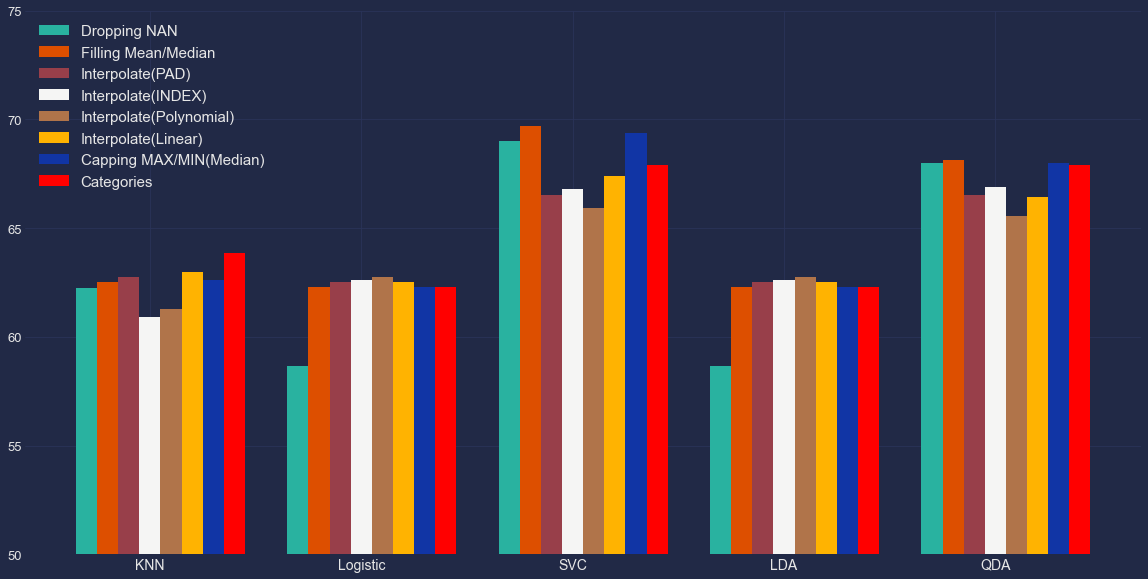

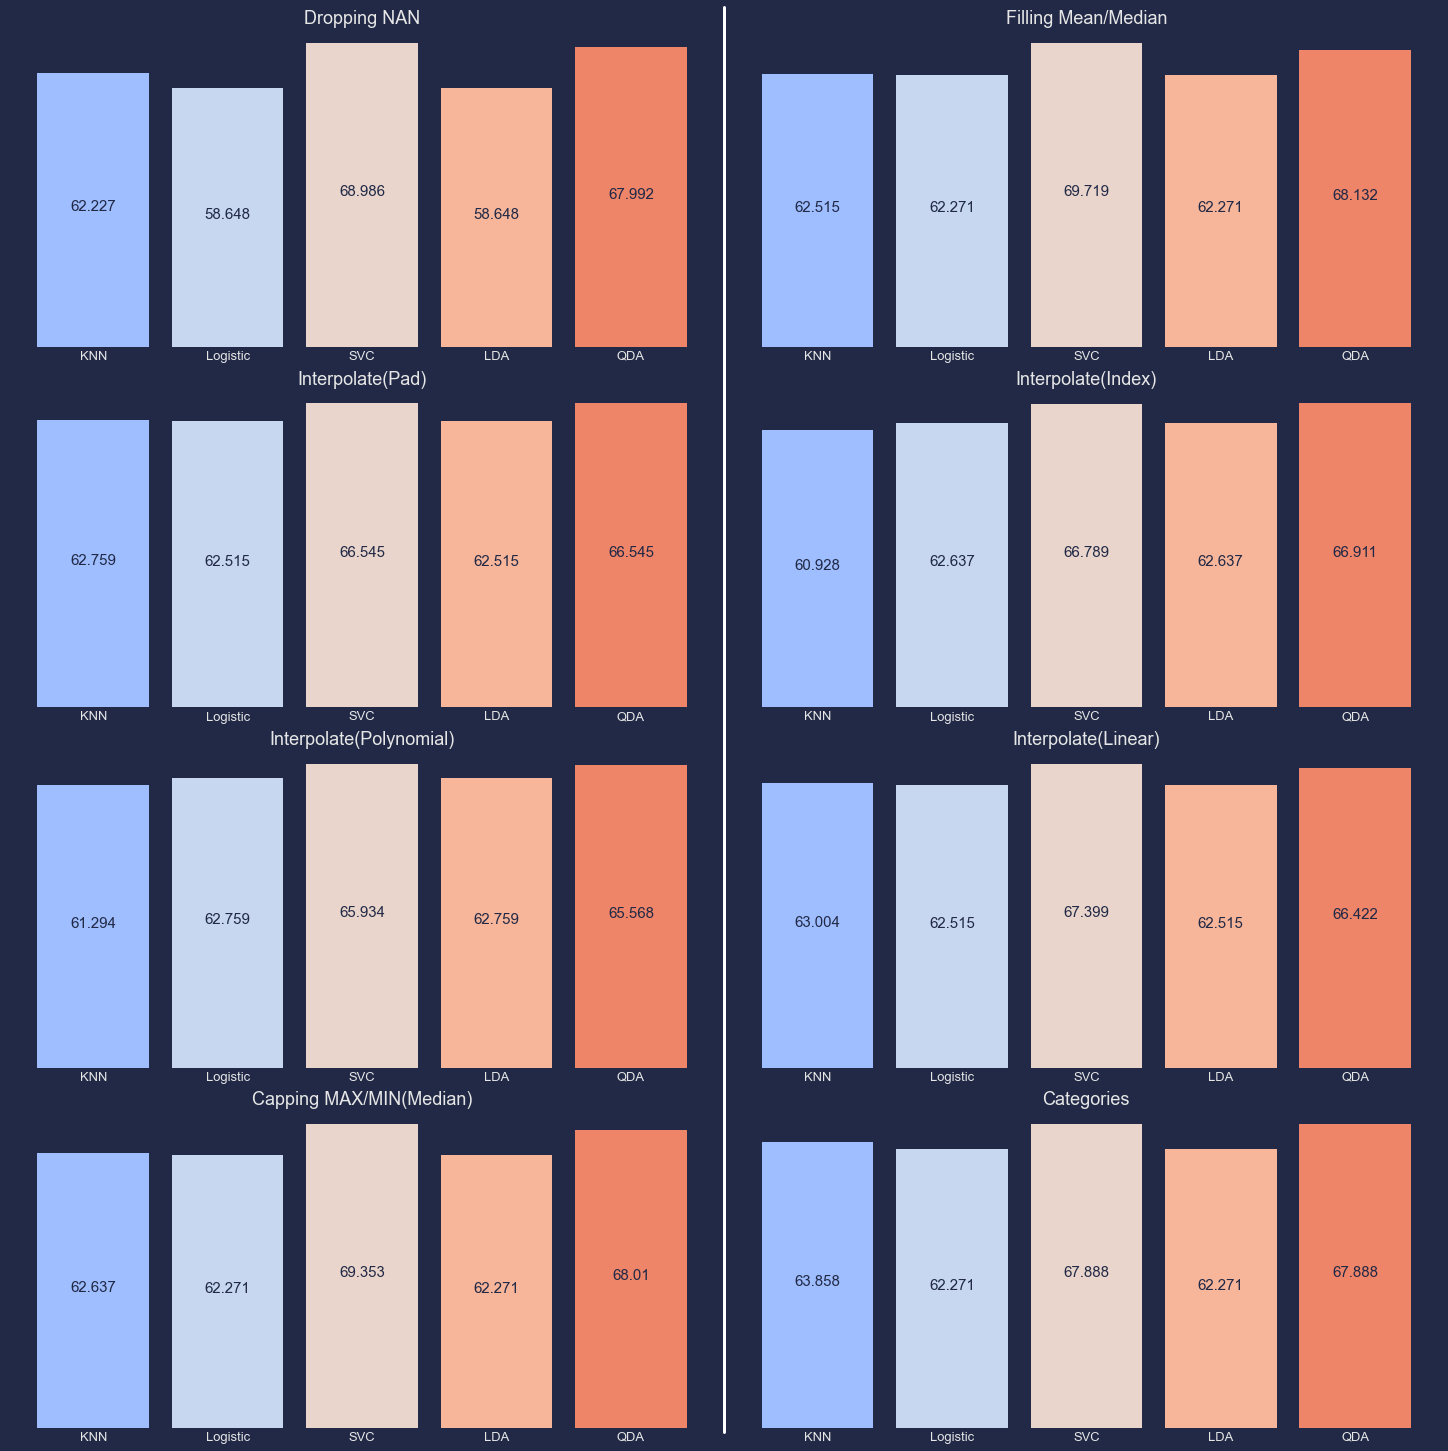

In [21]:
Graph(accuracies)
Graphs(accuracies)

-----------
## Third, we will  do the exploratory data analysis(EDA)

After Running our models with diffirent filling methods we found that filling with the medain or mean and using the SVC model gave the best accuracy 69.719% 
so now we will use this dataframe in our EDA

#### Using the Data Description on kaggle and Bureau indian standards (BIS) to categorize our data and calculate the Water quality index (WQI)

In [22]:
# Types Functions
def PH_Types(X):
    if X > 9:
        return "Alkaline water"
    elif (X <= 9 and X > 8):
        return "Bottled alkaline waters"
    elif (X <= 8 and X > 7.5 ):
        return "Ocean water"   
    elif(X == 7.5 ):
        return "Tap water"
    elif(X < 7.5 and X >=6.5):
        return "Common bottled waters"
    elif(X < 6.5 and X >=5.5):
        return "Distilled water"
    else:
        return "Acidic water"
def Hardness_types(X):
    if (X >=0  and X < 17.1):
        return "Soft"
    elif (X >= 17.1 and X < 60):
        return "Slightly hard"
    elif (X >= 60 and X < 120 ):
        return "Moderately hard"   
    elif(X >= 120 and X < 180):
        return "Hard"
    else:
         return "Very Hard"
# BIS Standrds
## PH 7.5
## TDS 1250
## Sulfate 300
## Hardness 400
## Turbidity 3
##chloromines 4

def PH (X) :
    if 6.5<=X<=8.5:
        return 1
    elif X>8.5 or X<6.5:
        return 0
    else:
        return None
def Hardness(X):
    if 200<=X<=600:
        return 1
    elif 600<=X or 200>X:
        return 0
    else:
        return None
def TDS_solids(X):
    if 500<=X<=2000:
        return 1
    elif 2000<X or 500>X:
        return 0
    else:
        return None
def Chloramines(X):
    if X<=4:
        return 1
    elif 4<X:
        return 0
    else:
        return None
def Turbidity(X):
    if 1<=X<=5:
        return 1
    elif 5<X or 1>X:
        return 0
    else:
        return None
def Sulfate(X):
    if 200<=X<=400:
        return 1
    elif 400<X or 200>X:
        return 0
    else:
        return None
# Kaggle
##conductivity 400
##Trihalomethanes 400
##conductivity 400
## Organic Carbon 10
def EC(X):
    if X<=400:
        return 1
    elif 400<X:
        return 0
    else:
        return None
def Trihalomethanes(X):
    if X<0.08:
        return 0
    elif 0.08<=X:
        return 1
    else:
        return None
def TOC(X):
    if X<10:
        return 1
    elif 10<=X:
        return 0
    else:
        return None

# Water Qualitiy Index 
def WQI(X):
    PH = 7.5
    TDS = 1250
    Sulfate = 300
    Hardness = 400
    Turbidity = 3
    chloromines = 4
    conductivity = 400
    Trihalomethanes = 400
    conductivity = 400
    Organic_Carbon =10
    K=sum((1/PH,1/TDS,1/Sulfate,1/Hardness,1/Turbidity,1/chloromines,
        1/conductivity,1/Trihalomethanes,1/conductivity,1/Organic_Carbon))
    PH_weight = K/PH
    TDS_weight = K/TDS
    Sulfate_weight = K/Sulfate
    Hardness_weight = K/Hardness
    Turbidity_weight = K/Turbidity
    chloromines_weight = K/chloromines
    conductivity_weight = K/conductivity
    Trihalomethanes_weight = K/Trihalomethanes
    conductivity_weight = K/conductivity
    Organic_Carbon_weight = K/Organic_Carbon
    weights=np.array((K/PH,K/TDS, K/Sulfate, K/Hardness, K/Turbidity, K/chloromines, K/conductivity, K/Trihalomethanes,K/Organic_Carbon))
    Qualities=np.array((((X["ph"]-7)/(PH-7))*100,(X["Solids"]/TDS)*100,X["Sulfate"]/Sulfate*100,
                            (X["Hardness"]/Hardness*100),(X["Turbidity"]/Turbidity*100),(X["Chloramines"]/chloromines*100),
                            (X["Conductivity"]/conductivity*100), (X["Trihalomethanes"]/Trihalomethanes*100),(X["Organic_carbon"]/Organic_Carbon)*100))
    Water_Quality_Index=np.dot(weights,Qualities)
    return Water_Quality_Index

def WQI_Types(X):
    if (X >=0  and X < 25):
        return "Excellent"
    elif (X >= 25 and X < 50):
        return "Slightly polluted"
    elif (X >= 50 and X < 75 ):
        return "Moderately polluted"   
    elif(X >= 75 and X < 180):
        return "Polluted"
    else:
         return "Excessively polluted"

f_df["PH_Test"]=f_df.ph.apply(lambda x: PH(x))
f_df["Hardness_Test"]=f_df.Hardness.apply(lambda x: Hardness(x))
f_df["Conductivity_Test"]=f_df.Conductivity.apply(lambda x: EC(x))
f_df["Solids_Test"]=f_df.Solids.apply(lambda x: TDS_solids(x))
f_df["Chloramines_Test"]=f_df.Chloramines.apply(lambda x: Chloramines(x))
f_df["Turbidity_Test"]=f_df.Turbidity.apply(lambda x: Turbidity(x))
f_df["Organic_Carbon_Test"]=f_df.Organic_carbon.apply(lambda x: TOC(x))
f_df["Trihalomethane_Test"]=f_df.Trihalomethanes.apply(lambda x: Trihalomethanes(x))
f_df["Sulphate_Test"]=f_df.Sulfate.apply(lambda x: Sulfate(x))
f_df["PH_Types"]=f_df.ph.apply(lambda x: PH_Types(x))
f_df["Hardness_Types"]=f_df.Hardness.apply(lambda x: Hardness_types(x))
WQI_array=[]
for x in range(f_df.shape[0]):
    WQI_array.append(WQI(f_df.iloc[x][:9]))
f_df["WQI"]=WQI_array
f_df["WQI_Types"]=f_df.WQI.apply(lambda x: WQI_Types(x))


#### Let's see the  potability of our samples

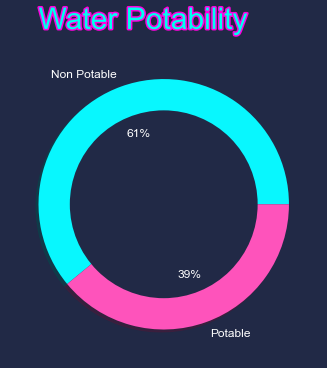

In [23]:
figure, (axis) = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True)
axis.pie([(f_df["Potability"].count()-(f_df["Potability"]==1).sum()),(f_df["Potability"]==1).sum()], labels = ['Non Potable','Potable'], autopct='%.0f%%',shadow=True,textprops={'fontsize': 12,'color':'w'})
circle=Circle(xy=(0,0),radius=0.75,facecolor='#212946')
axis.add_patch(circle)
txt = axis.text(-1, 1.4, "Water Potability",
              size=30,
              color='#00FFEF',
              path_effects=[pe.withStroke(linewidth=3, foreground='#FF00DE')])

61% of our samples are not safe for drinking

#### Classifying the water samples source according to their PH value

<AxesSubplot:xlabel='count', ylabel='PH_Types'>

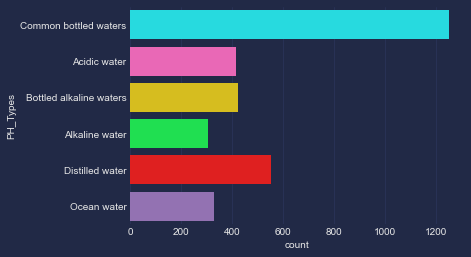

In [24]:
sns.countplot(y = "PH_Types", data = f_df)


#### Analyzing the hardness of our samples

<AxesSubplot:xlabel='count', ylabel='Hardness_Types'>

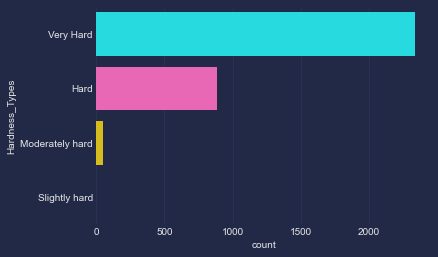

In [25]:
sns.countplot(y = "Hardness_Types", data = f_df)

Most of the samples contains high quantity of Calcium and Magnesium Salt

#### Classifying our water samples accorging to their WQI

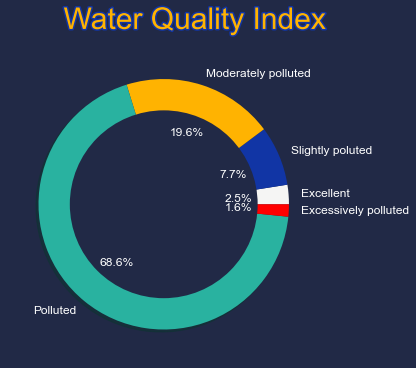

In [26]:

figure, (axis) = plt.subplots(1, 1,figsize=(10,5),constrained_layout = True)
axis.pie([(f_df["WQI_Types"].count()-(f_df["WQI_Types"]!="Excellent").sum()),(f_df["WQI_Types"]=="Slightly polluted").sum(),
    (f_df["WQI_Types"]=="Moderately polluted").sum(),(f_df["WQI_Types"]=="Polluted").sum(),(f_df["WQI_Types"]=="Excessively polluted").sum()],
     labels = ['Excellent',"Slightly poluted","Moderately polluted","Polluted",'Excessively polluted'],
      autopct='%1.1f%%',shadow=True,textprops={'fontsize': 12,'color':'w'},colors=['#F5F5F4','#1135A5','#FFB301','#29B2A0','r'])

circle=Circle(xy=(0,0),radius=0.75,facecolor='#212946')
axis.add_patch(circle)
txt = axis.text(-0.8, 1.4, "Water Quality Index",
              size=30,
              color='#FFB301',
              path_effects=[pe.withStroke(linewidth=3, foreground='#1135A5')])


Most of the samples are polluted according to Bureau Indian standards and Kaggle info